#### Seismic Forward Modelling with PyFWI
https://pyfwi.readthedocs.io/en/latest/sub_doc/fwi_example.html

In [2]:
# External Dependencies

import numpy as np

import matplotlib.pyplot as plt

import PyFWI.wave_propagation as wave
import PyFWI.acquisition as acq
import PyFWI.seiplot as splt

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\pytools\persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


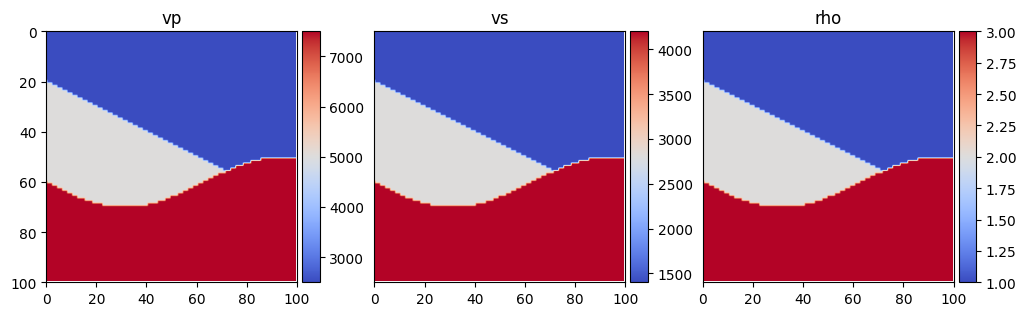

In [9]:
# Model

nx, nz = 100, 100

def sample_structure():
    structure = np.full((nx, nz), 2)
    for i in range(nz):
            for j in range(nx):
                # Waving shape
                depth_1 = 20 + j * 0.5
                depth_2 = 60 + 10 * np.sin(j * 0.05)
                if i < depth_2:
                    if i < depth_1:
                        structure[i, j] = 1
                    else:
                        structure[i, j] = 2
                else:
                     structure[i, j] = 3
    return structure

structure = sample_structure()

model = {
    'vp': (structure * 2500).astype(float),
    'vs': (structure * 1400).astype(float),
    'rho': (structure).astype(float)
}

# Plot model
im = splt.earth_model(model, cmap='coolwarm')

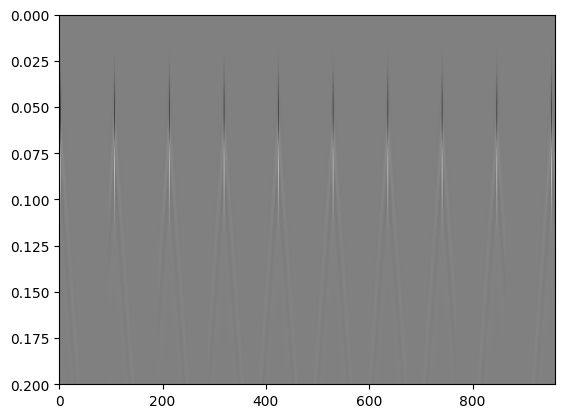

In [10]:
# Forward Modelling

# Model shape
model_shape = model[[*model][0]].shape

# Input parameters
inpa = {
    'ns': 10,  # Number of sources
    'sdo': 4,  # Order of FD
    'fdom': 15,  # Central frequency of source
    'dh': 10,  # Spatial sampling rate
    'dt': 0.002,  # Temporal sampling rate
    'acq_type': 1,  # Type of acquisition (0: crosswell, 1: surface, 2: both)
    't': 0.2,  # Length of operation
    'npml': 20,  # Number of PML
    'pmlR': 1e-5,  # Coefficient for PML (No need to change)
    'pml_dir': 2,  # type of boundary layer
}

seisout = 0 # Type of output 0: Pressure

inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance


# Source and receiver locations

offsetx = inpa['dh'] * model_shape[1]
depth = inpa['dh'] * model_shape[0]

src_loc, rec_loc, n_surface_rec, n_well_rec = acq.acq_parameters(inpa['ns'],
                                                                 inpa['rec_dis'],
                                                                 offsetx,
                                                                 depth,
                                                                 inpa['dh'],
                                                                 inpa['sdo'],
                                                                 acq_type=inpa['acq_type'])

# Create the source
src = acq.Source(src_loc, inpa['dh'], inpa['dt'])
src.Ricker(inpa['fdom'])

# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape,
                        n_well_rec=n_well_rec,
                        components=seisout, chpr=0)

# Call the forward modelling
d_obs = W.forward_modeling(model, show=False)  # show=True can show the propagation of the wave


# Plot shots
plt.imshow(d_obs["taux"], cmap='gray',
           aspect="auto", extent=[0, d_obs["taux"].shape[1], inpa['t'], 0])
plt.show()